<a href="https://colab.research.google.com/github/ameyas1/Gluoncv-Notebooks/blob/master/Mask_NotMask_Gluoncv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet-cu101mkl gluoncv
# !pip install gluoncv --upgrade

     |████████████████████████████████| 712.3MB 26kB/s 
     |████████████████████████████████| 819kB 53.9MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx 
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv import utils
from gluoncv.model_zoo import get_model
import numpy as np
import pandas as pd

In [3]:
from mxnet import init
from mxnet import autograd as ag
from mxnet.gluon import nn

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle datasets download -d dhruvmak/face-mask-detection

 95% 185M/194M [00:02<00:00, 82.0MB/s]
100% 194M/194M [00:02<00:00, 74.5MB/s]


In [6]:
!unzip -q /content/face-mask-detection.zip

In [7]:
labels=['with_mask','without_mask']
classes = len(labels)

epochs = 25
lr = 0.0001
per_device_batch_size = 16


lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

In [8]:
ctx

[gpu(0)]

In [9]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256, keep_ratio=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset('/content/dataset').transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [11]:
for x,y in train_data:
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


with_mask


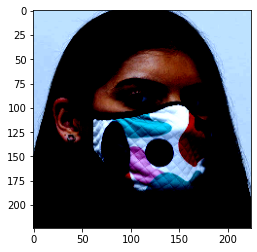

In [12]:
plt.imshow(nd.transpose(nd.squeeze(x[1]),(1,2,0)).asnumpy())
print(labels[int(y[1].asnumpy())])

In [13]:
net = gcv.model_zoo.get_model('Resnest101', pretrained=True)

189137KB [00:02, 68624.45KB/s]                            


In [14]:
net.fc = nn.Dense(classes)

In [15]:
net

ResNeSt(
  (conv1): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (5): Activation(relu)
    (6): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (relu): Activation(relu)
  (maxpool): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (layer1): HybridSequential(
    (0): Bottleneck(
      (conv1): Conv2D(128 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm

In [16]:
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
# with network.name_scope():
#     network.output = nn.Dense(classes,activation='sigmoid')
net.fc.initialize(init.Xavier(), ctx = ctx)
net.collect_params().reset_ctx(ctx)




net.hybridize()

trainer = gluon.Trainer(net.collect_params(), 'adam', {
                        'learning_rate': lr})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [17]:
import time
import tqdm

In [18]:
len(train_data)

28

In [19]:
lr_counter = 0
num_batch = len(train_data)

min_loss = np.inf

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        print('Decreasing learning rate')
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in tqdm.tqdm(enumerate(train_data)):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)

        with ag.record():
            outputs = [net(nd.squeeze(X)) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    if min_loss > train_loss:
      min_loss = train_loss
      net.save_parameters('face_mask.params')
      print('loss decreases...Saving Model')



    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, time.time() - tic))



28it [00:23,  1.20it/s]
0it [00:00, ?it/s]

loss decreases...Saving Model
[Epoch 0] Train-acc: 0.923, loss: 0.182 | time: 23.8


28it [00:14,  1.87it/s]
0it [00:00, ?it/s]

loss decreases...Saving Model
[Epoch 1] Train-acc: 0.975, loss: 0.076 | time: 15.5


28it [00:15,  1.82it/s]
0it [00:00, ?it/s]

[Epoch 2] Train-acc: 0.975, loss: 0.083 | time: 15.3


28it [00:15,  1.83it/s]
0it [00:00, ?it/s]

loss decreases...Saving Model
[Epoch 3] Train-acc: 0.982, loss: 0.051 | time: 15.9


28it [00:15,  1.79it/s]
0it [00:00, ?it/s]

[Epoch 4] Train-acc: 0.975, loss: 0.084 | time: 15.7


28it [00:15,  1.76it/s]
0it [00:00, ?it/s]

[Epoch 5] Train-acc: 0.973, loss: 0.061 | time: 15.9


28it [00:16,  1.74it/s]
0it [00:00, ?it/s]

[Epoch 6] Train-acc: 0.968, loss: 0.063 | time: 16.2


28it [00:16,  1.73it/s]
0it [00:00, ?it/s]

loss decreases...Saving Model
[Epoch 7] Train-acc: 0.984, loss: 0.048 | time: 16.6


28it [00:15,  1.76it/s]
0it [00:00, ?it/s]

loss decreases...Saving Model
[Epoch 8] Train-acc: 0.991, loss: 0.019 | time: 16.4


28it [00:15,  1.80it/s]
0it [00:00, ?it/s]

[Epoch 9] Train-acc: 0.975, loss: 0.062 | time: 15.6
Decreasing learning rate


28it [00:16,  1.72it/s]
0it [00:00, ?it/s]

[Epoch 10] Train-acc: 0.973, loss: 0.078 | time: 16.4


28it [00:16,  1.75it/s]
0it [00:00, ?it/s]

[Epoch 11] Train-acc: 0.984, loss: 0.039 | time: 16.1


28it [00:15,  1.76it/s]
0it [00:00, ?it/s]

[Epoch 12] Train-acc: 0.977, loss: 0.046 | time: 16.0


28it [00:15,  1.75it/s]
0it [00:00, ?it/s]

[Epoch 13] Train-acc: 0.977, loss: 0.053 | time: 16.0


28it [00:15,  1.76it/s]
0it [00:00, ?it/s]

[Epoch 14] Train-acc: 0.973, loss: 0.041 | time: 16.0


28it [00:15,  1.76it/s]
0it [00:00, ?it/s]

[Epoch 15] Train-acc: 0.980, loss: 0.052 | time: 16.0


28it [00:16,  1.72it/s]
0it [00:00, ?it/s]

[Epoch 16] Train-acc: 0.982, loss: 0.052 | time: 16.3


28it [00:16,  1.72it/s]
0it [00:00, ?it/s]

[Epoch 17] Train-acc: 0.986, loss: 0.074 | time: 16.3


28it [00:16,  1.73it/s]
0it [00:00, ?it/s]

[Epoch 18] Train-acc: 0.989, loss: 0.042 | time: 16.2


28it [00:16,  1.74it/s]
0it [00:00, ?it/s]

[Epoch 19] Train-acc: 0.995, loss: 0.021 | time: 16.2
Decreasing learning rate


28it [00:16,  1.71it/s]
0it [00:00, ?it/s]

[Epoch 20] Train-acc: 0.993, loss: 0.024 | time: 16.4


28it [00:16,  1.73it/s]
0it [00:00, ?it/s]

[Epoch 21] Train-acc: 0.986, loss: 0.057 | time: 16.2


28it [00:16,  1.73it/s]
0it [00:00, ?it/s]

[Epoch 22] Train-acc: 0.993, loss: 0.022 | time: 16.3


28it [00:16,  1.75it/s]
0it [00:00, ?it/s]

[Epoch 23] Train-acc: 0.991, loss: 0.028 | time: 16.1


28it [00:15,  1.76it/s]

[Epoch 24] Train-acc: 0.989, loss: 0.032 | time: 16.1


In [20]:
net.load_parameters('/content/face_mask.params', ctx=ctx)

100%|██████████| 145/145 [00:00<00:00, 4702.57KB/s]


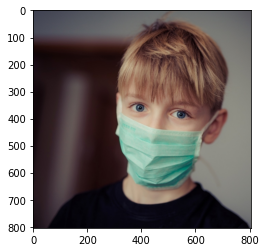

In [21]:
url = 'https://images.glaciermedia.ca/polopoly_fs/1.23534158.1584895045!/fileImage/httpImage/image.jpg_gen/derivatives/landscape_804/face-mask.jpg'
im_fname = utils.download(url)

img = image.imread(im_fname)

plt.imshow(img.asnumpy())
plt.show()

In [22]:
img = gcv.data.transforms.presets.imagenet.transform_eval(img)

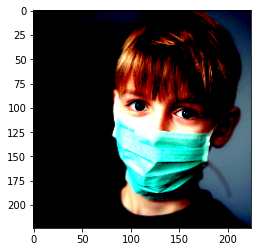

In [23]:
plt.imshow(nd.transpose(nd.squeeze(img), (1,2,0)).asnumpy())
plt.show()

In [24]:
img = img.copyto(ctx[0])

In [25]:
predictions = net(img)

In [26]:
prob =nd.softmax(predictions)

In [27]:
prob


[[9.9998701e-01 1.2940908e-05]]
<NDArray 1x2 @gpu(0)>

In [28]:
ind =nd.argmax(prob)
ind


[0.]
<NDArray 1 @gpu(0)>

In [29]:
print('The input picture is classified to be')

class_index = ind[0].astype('int').asscalar()
class_label = labels[class_index]
class_prob = prob[0][class_index]
print('[%s], with probability %.3f.'%(class_label, class_prob.asscalar()*100))

The input picture is classified to be
[with_mask], with probability 99.999.


In [30]:
def predict_url(file_path,ctx):
  url = file_path
  im_fname = utils.download(url)
  img = image.imread(im_fname)
  plt.imshow(img.asnumpy())
  plt.show()
  # img = gcv.data.transforms.presets.imagenet.transform_eval(img)
  img = transform_test(img).expand_dims(0)
  plt.imshow(nd.transpose(nd.squeeze(img), (1,2,0)).asnumpy())
  plt.show()
  img = img.copyto(ctx[0])
  predictions = net(img)
  prob =nd.softmax(predictions)
  ind =nd.argmax(prob)
  print('The input picture is classified to be')

  class_index = ind.astype('int').asscalar()
  class_label = labels[class_index]
  class_prob = prob[0][class_index]
  print('[%s], with probability %.3f.'%(class_label, class_prob.asscalar()*100))



100%|██████████| 65/65 [00:00<00:00, 4210.89KB/s]

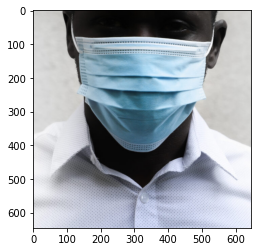

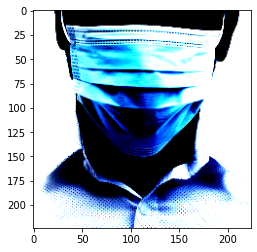

The input picture is classified to be
[with_mask], with probability 99.958.


In [31]:
predict_url('https://www.statnews.com/wp-content/uploads/2020/05/AdobeStock_345360112-645x645.jpeg',ctx)

91KB [00:00, 822.85KB/s]                        


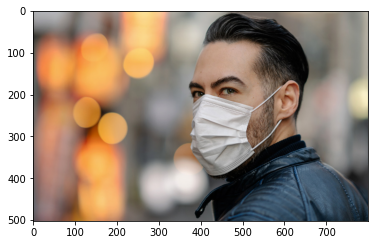

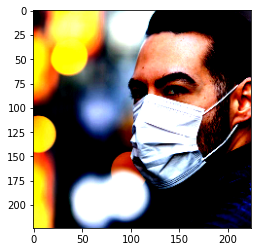

The input picture is classified to be
[with_mask], with probability 99.988.


In [32]:
predict_url('https://news.fullerton.edu/2020sp/_images/Masculinity-Wearing-Face-Mask.jpg',ctx)

23KB [00:00, 4952.46KB/s]             

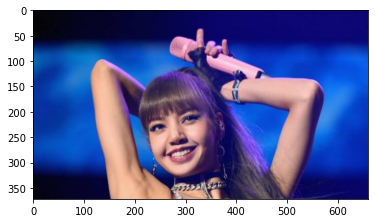

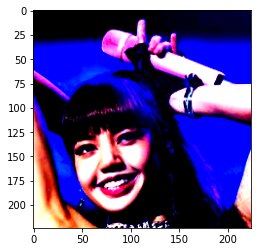

The input picture is classified to be
[without_mask], with probability 99.986.


In [33]:
predict_url('https://akns-images.eonline.com/eol_images/Entire_Site/2019322/rs_600x600-190422210546-e-asia-lisa-blackpink-thumbnail-GettyImages-1136616056.jpg?fit=around|660:372&output-quality=90&crop=660:372;center,top',ctx)

100%|██████████| 965/965 [00:00<00:00, 2553.27KB/s]


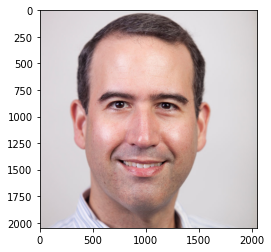

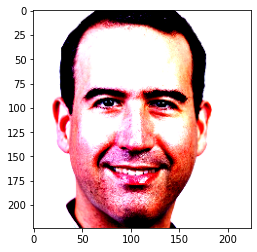

The input picture is classified to be
[without_mask], with probability 99.999.


In [34]:
predict_url('https://images.news.iu.edu/dams/ngeskt3qtg_actual.jpg',ctx)

72KB [00:00, 4009.85KB/s]             

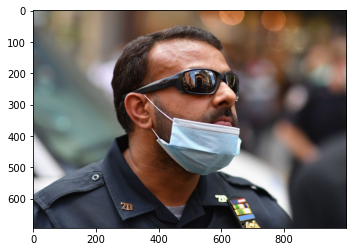

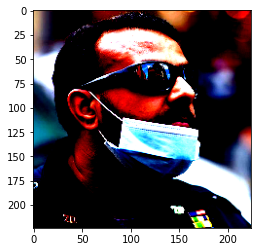

The input picture is classified to be
[with_mask], with probability 98.664.


In [35]:
predict_url('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/ilzf21UlDDZc/v1/1000x-1.jpg', ctx)